In [588]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame 

import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib as mpl
import matplotlib.font_manager as fm
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'Malgun Gothic' 
plt.rcParams["font.size"] = 10
%matplotlib inline 


from datetime import datetime, timedelta 
from statsmodels.tsa.arima_model import ARIMA 

from sklearn.preprocessing import StandardScaler
# import os

In [360]:
test = pd.read_csv("data/test.csv", sep = ",")
train = pd.read_csv("data/train.csv", sep =",")
submission = pd.read_csv("data/submission.csv")

## Clustering by Ratio(미터ID마다 시간별 값/lag(1일, 7일))

In [450]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

In [432]:
train2 = train.copy()
train2.reset_index(level=0, inplace=True)
v = train2.columns[1:12]
train3 = pd.melt(train2, id_vars=['Time'], value_vars=train2.columns[1:1292])

In [433]:
train4 = train3.groupby(['Time','variable'])['value'].agg({'value':'mean'}).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



In [434]:
train5 = train4.copy()
train5['lag1'] = train5.groupby(['variable'])['value'].shift(1)
train5['lag7'] = train5.groupby(['variable'])['value'].shift(7)
train5 = train5.fillna(0)
train5['ratio1'] = train5['value']/(train5['lag1']+1)
train5['ratio7'] = train5['value']/(train5['lag7']+1)
train5.head(2)

Time variable  value  lag1  lag7  ratio1  ratio7
0  2018-02-15 00:00:00     X100  0.793   0.0   0.0   0.793   0.793
1  2018-02-15 00:00:00    X1000  0.226   0.0   0.0   0.226   0.226

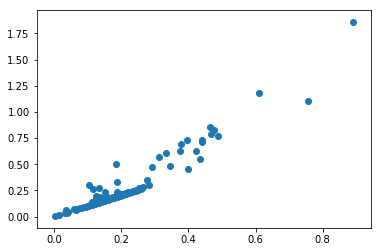

In [436]:
train6 = train5.groupby(['variable']).agg({'ratio1':'mean','ratio7':'mean'}).reset_index()
featureTr = train6.copy()
plt.scatter(feature['ratio1'], feature['ratio7'])

In [438]:
featureTr['id'] = [int(s[1:]) for s in featureTr['variable']]
featureTr2 = featureTr.iloc[:, 1:]
featureTr2

ratio1    ratio7    id
0     0.389896  0.542031   100
1     0.325501  0.347772  1000
2     0.389982  0.442093  1001
3     0.285310  0.299337  1002
4     0.259807  0.276981  1003
5     0.245632  0.254742  1004
6     0.311146  0.332397  1005
7     0.167652  0.175221  1006
8     0.210551  0.216589  1007
9     0.254806  0.283713  1008
10    0.302267  0.317933  1009
11    0.325585  0.542242   101
12    0.291339  0.299233  1010
13    0.319439  0.325492  1011
14    0.268724  0.285809  1012
15    0.310018  0.330199  1013
16    0.250192  0.267090  1014
17    0.234904  0.249394  1015
18    0.317412  0.341248  1016
19    0.249915  0.264890  1017
20    0.259501  0.277356  1018
21    0.363944  0.372385  1019
22    0.269758  0.278784  1020
23    0.292624  0.305385  1021
24    0.270765  0.277368  1022
25    0.229290  0.237064  1023
26    0.272117  0.285909  1024
27    0.316294  0.325328  1025
28    0.221843  0.231271  1026
29    0.312840  0.328359  1027
...        ...       ...   ...
1261  0.373694  0.402236   972
1262  0.206496  0.220832   973
1263  0.388876  0.412415   974
1264  0.201258  0.205316   975
1265  0.223918  0.228761   976
1266  0.317911  0.333649   977
1267  0.369155  0.393678   978
1268  0.280629  0.293904   979
1269  0.398913  0.526267    98
1270  0.305643  0.324461   980
1271  0.122515  0.130698   981
1272  0.316981  0.333091   982
1273  0.242524  0.251593   983
1274  0.344679  0.357216   984
1275  0.270866  0.291135   985
1276  0.342080  0.360848   986
1277  0.268041  0.278909   987
1278  0.305650  0.327249   988
1279  0.284227  0.298231   989
1280  0.234930  0.267937    99
1281  0.269315  0.277635   990
1282  0.371656  0.389600   991
1283  0.323045  0.333421   992
1284  0.328602  0.336454   993
1285  0.311010  0.326494   994
1286  0.405583  0.419062   995
1287  0.254699  0.264539   996
1288  0.329498  0.345021   997
1289  0.359359  0.386620   998
1290  0.340037  0.349079   999

[1291 rows x 3 columns]

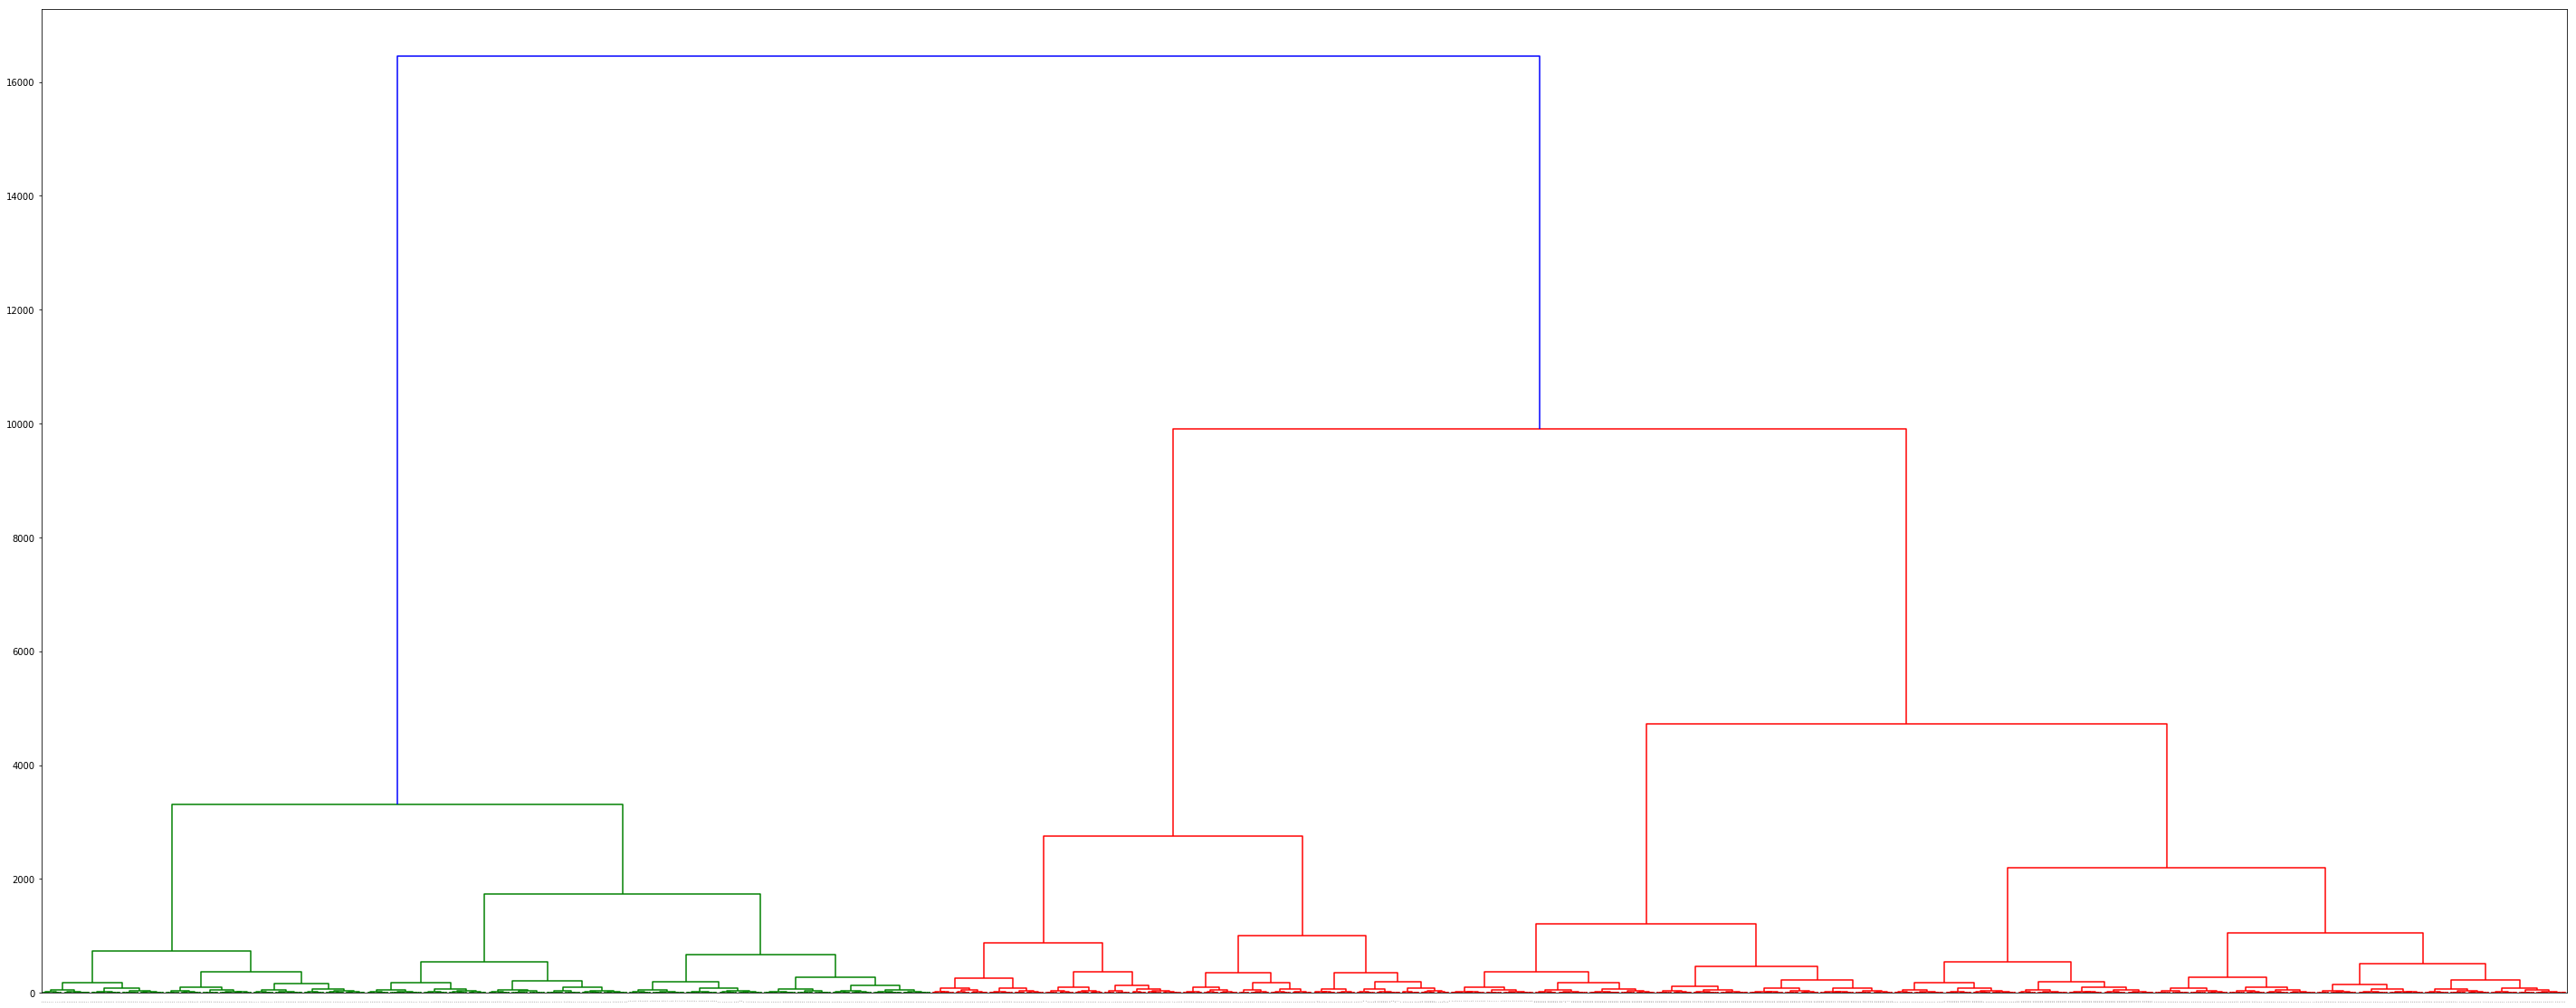

In [440]:
Z = linkage(featureTr2,'ward')

plt.figure(figsize=(50,20))
dendrogram(Z,
           leaf_rotation=100,
           leaf_font_size=1,
)
plt.show()

In [443]:
k=3
featureTr3 = featureTr.copy()
featureTr3 = featureTr3.drop(columns='id')
predict = fcluster(Z, k, criterion = 'maxclust')
featureTr3['cluster']=predict
train7 = pd.merge(train5, featureTr3, on ='variable',how='left')

c_1T = train7[train7['cluster']==1]
c_2T = train7[train7['cluster']==2]
c_3T = train7[train7['cluster']==3]

In [444]:
cnt_srs_1T = c_1T.groupby('Time')['value'].mean()
cnt_srs_2T = c_2T.groupby('Time')['value'].mean()
cnt_srs_3T = c_3T.groupby('Time')['value'].mean()

In [445]:
import plotly.graph_objs as go
def scatter_plot(cnt_srs, color, showlegend1=False, name1 = ""):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        name = name1,
        showlegend=showlegend1,
        marker=dict(
            color=color,
        ),
    )
    return trace

In [446]:
trace_1T = scatter_plot(cnt_srs_1T, 'yellow', True ,'Cluster_1')
trace_2T = scatter_plot(cnt_srs_2T, 'green', True ,'Cluster_2')
trace_3T = scatter_plot(cnt_srs_3T, 'red', True ,'Cluster_3')

In [447]:
import plotly.offline as py
layout = go.Layout(
    height=500,
    width=1000,
    #paper_bgcolor='rgb(233,233,233)',
    title='Train Clustering_3'
)

data = [trace_1T,trace_2T, trace_3T]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [453]:
test2 = test.copy()

In [457]:
test2.reset_index(level=0, inplace=True)
v = test2.columns[1:12]
test3 = pd.melt(test2, id_vars=['Time'], value_vars=test2.columns[1:1292])

In [458]:
test4 = test3.groupby(['Time','variable'])['value'].agg({'value':'mean'}).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



In [459]:
test5 = test4.copy()
test5['lag1'] = test5.groupby(['variable'])['value'].shift(1)
test5['lag7'] = test5.groupby(['variable'])['value'].shift(7)
test5 = test5.fillna(0)
test5['ratio1'] = test5['value']/(test5['lag1']+1)
test5['ratio7'] = test5['value']/(test5['lag7']+1)
test5.head(2)

Time variable     value  lag1  lag7    ratio1    ratio7
0  2017-08-29 10:00:00      X10  3.042443   0.0   0.0  3.042443  3.042443
1  2017-08-29 10:00:00     X102  0.806000   0.0   0.0  0.806000  0.806000

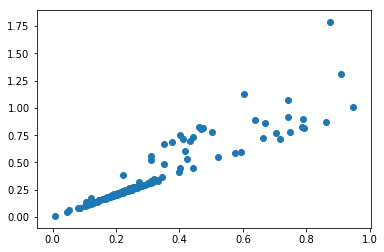

In [460]:
test6 = test5.groupby(['variable']).agg({'ratio1':'mean','ratio7':'mean'}).reset_index()
feature = test6
plt.scatter(feature['ratio1'], feature['ratio7'])

In [461]:
feature['id'] = [int(s[1:]) for s in feature['variable']]
feature2 = feature.iloc[:, 1:]
feature2

ratio1    ratio7   id
0    0.748881  0.781495   10
1    0.469327  0.807009  102
2    0.351904  0.665737  105
3    0.400738  0.447330  106
4    0.220319  0.385870  107
5    0.351174  0.483736  110
6    0.271874  0.325006  111
7    0.377484  0.690035  116
8    0.443285  0.735217  120
9    0.432406  0.698408  123
10   0.460613  0.829722  124
11   0.474409  0.812337  125
12   0.120700  0.178562  126
13   0.300246  0.312027  130
14   0.272006  0.283098  132
15   0.234149  0.248029  133
16   0.234557  0.247504  134
17   0.272655  0.285822  139
18   0.276972  0.289315  140
19   0.319799  0.344226  142
20   0.165592  0.169774  143
21   0.214042  0.226299  148
22   0.244777  0.252688  149
23   0.225592  0.237707  155
24   0.193097  0.200337  157
25   0.208627  0.219264  158
26   0.792509  0.811510   16
27   0.225987  0.227574  160
28   0.311622  0.326569  161
29   0.233343  0.242390  163
..        ...       ...  ...
170  0.201018  0.208659  457
171  0.137633  0.141454  459
172  0.130994  0.133862  460
173  0.184478  0.190819  462
174  0.179362  0.187128  468
175  0.081127  0.084720   47
176  0.270500  0.272789  470
177  0.202279  0.209352  472
178  0.149158  0.151985  473
179  0.201793  0.203770  481
180  0.862000  0.867240    5
181  0.788303  0.895604   50
182  0.948552  1.007288   51
183  0.908699  1.308905   55
184  0.668905  0.858148   59
185  0.703105  0.771494   61
186  0.221047  0.227880   62
187  0.425134  0.528830   67
188  0.743961  1.071526   68
189  0.575984  0.588086    7
190  0.401959  0.747664   70
191  0.050170  0.062077   73
192  0.501131  0.776961   75
193  0.311457  0.560970   76
194  0.874101  1.789482   80
195  0.418714  0.608160   82
196  0.602111  1.131949   87
197  0.311115  0.523360   88
198  0.411087  0.713258   91
199  0.105985  0.133872   94

[200 rows x 3 columns]

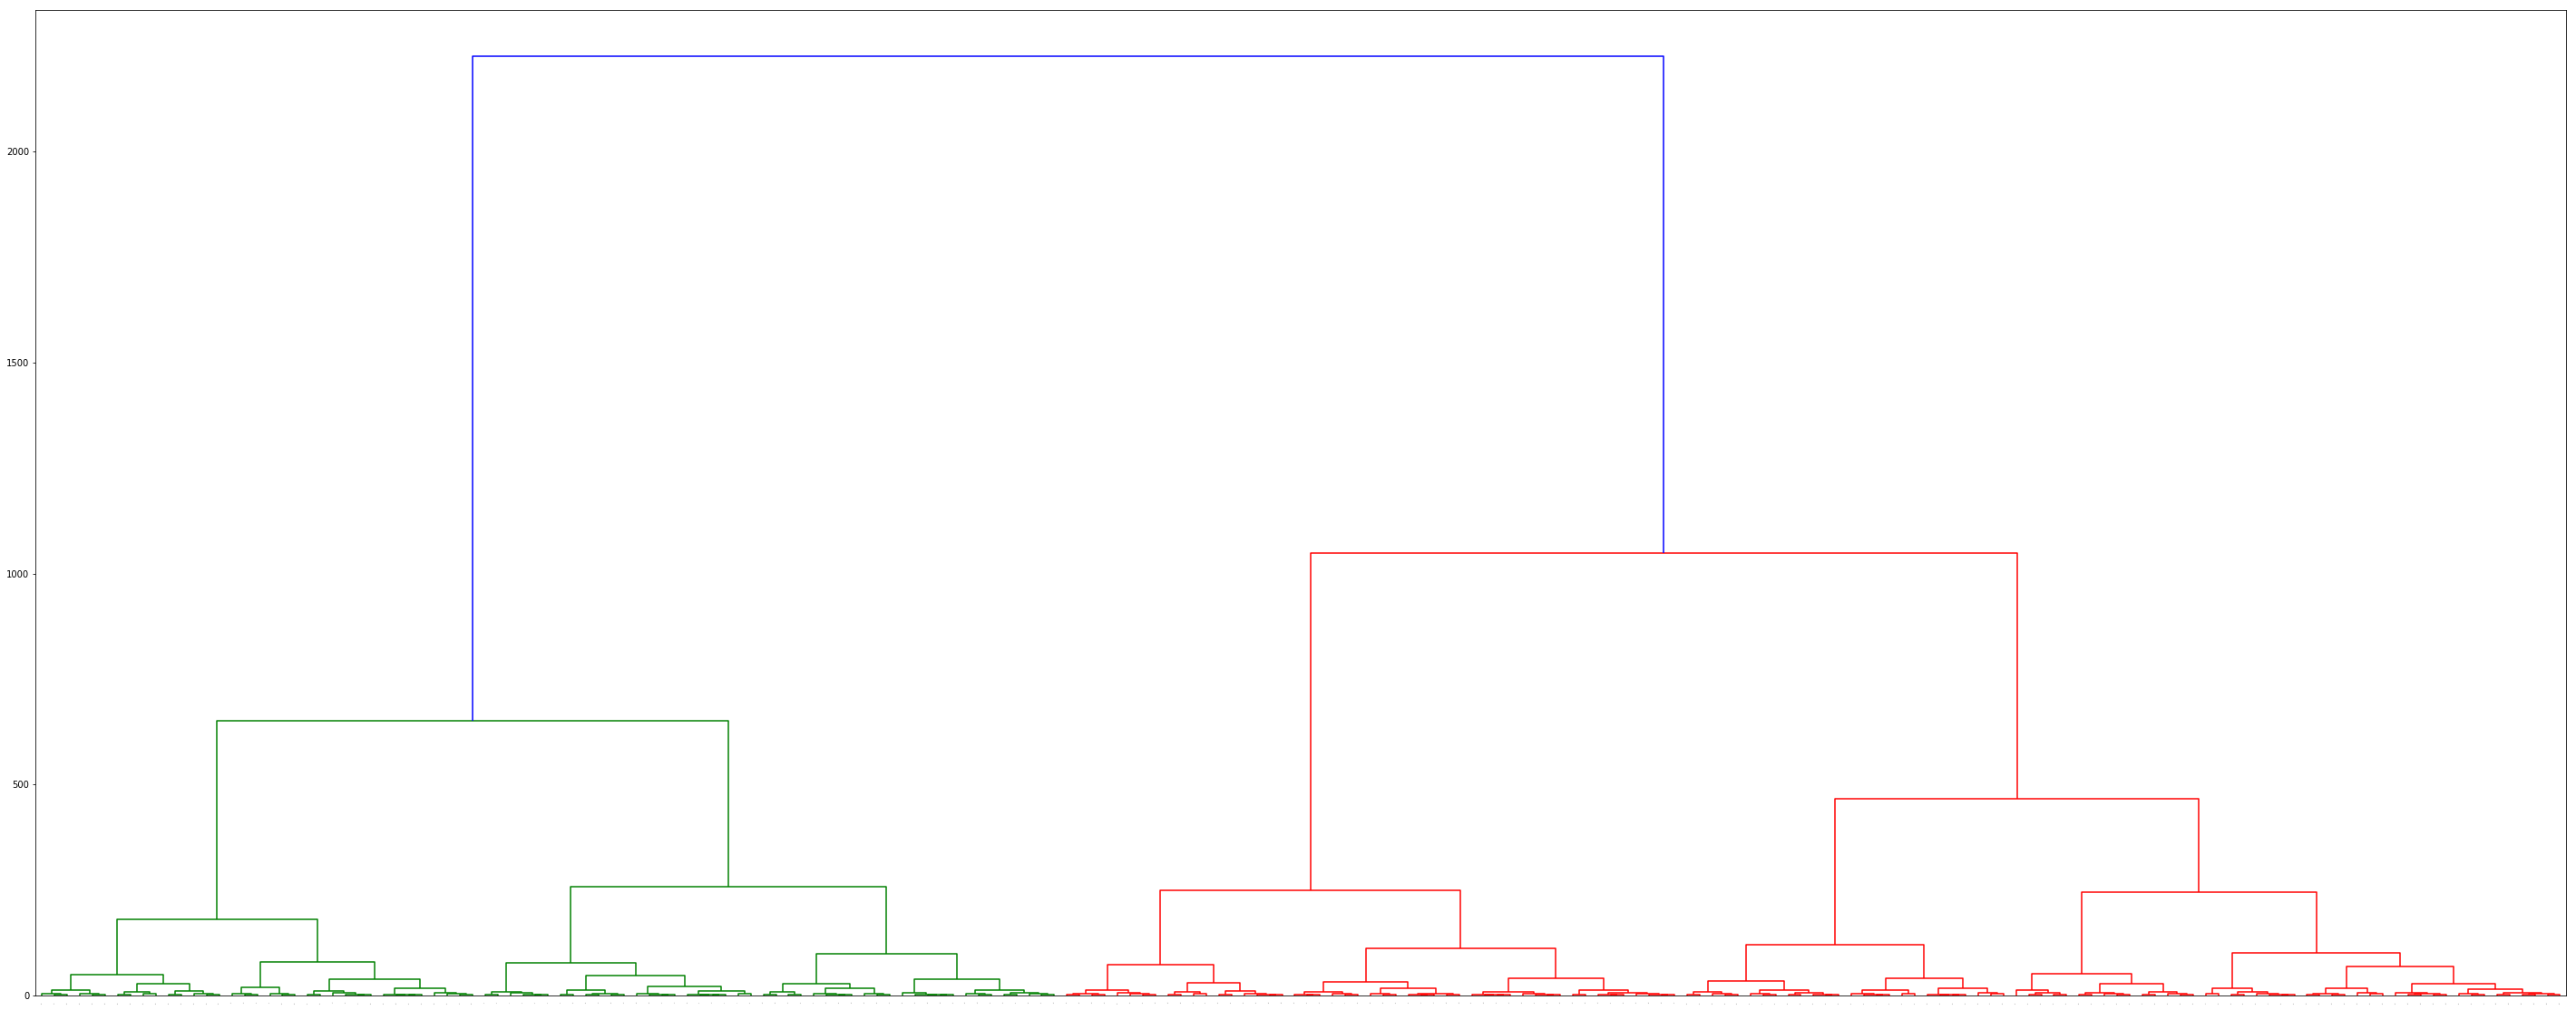

In [462]:
Z = linkage(feature2,'ward')

plt.figure(figsize=(50,20))
dendrogram(Z,
           leaf_rotation=100,
           leaf_font_size=1,
)
plt.show()

In [463]:
feature3 = feature3.drop(columns='id')

In [480]:
k=3
feature3 = feature.copy()
predict = fcluster(Z, k, criterion = 'maxclust')
feature3['cluster']=predict
test7 = pd.merge(test5, feature3, on ='variable',how='left')

c_1 = test7[test7['cluster']==1]
c_2 = test7[test7['cluster']==2]
c_3 = test7[test7['cluster']==3]
# c_4 = test7[test7['cluster']==4]

In [481]:
cnt_srs_1 = c_1.groupby('Time')['value'].mean()
cnt_srs_2 = c_2.groupby('Time')['value'].mean()
cnt_srs_3 = c_3.groupby('Time')['value'].mean()
# cnt_srs_4 = c_4.groupby('Time')['value'].mean()

In [482]:
import plotly.graph_objs as go
def scatter_plot(cnt_srs, color, showlegend1=False, name1 = ""):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        name = name1,
        showlegend=showlegend1,
        marker=dict(
            color=color,
        ),
    )
    return trace

In [483]:
trace_1 = scatter_plot(cnt_srs_1, 'yellow', True ,'Cluster_1')
trace_2 = scatter_plot(cnt_srs_2, 'green', True ,'Cluster_2')
trace_3 = scatter_plot(cnt_srs_3, 'red', True ,'Cluster_3')
# trace_4 = scatter_plot(cnt_srs_3, 'grey', True ,'Cluster_3')

In [484]:
import plotly.offline as py
layout = go.Layout(
    height=500,
    width=1000,
    #paper_bgcolor='rgb(233,233,233)',
    title='Test Clustering_2'
)

data = [trace_1,trace_2, trace_3]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [485]:
test7.groupby('cluster')['variable'].nunique()

cluster
1    81
2    49
3    70
Name: variable, dtype: int64

In [509]:
# TEST에서 각각의 클러스터에 해당하는 ID 추출
c1_testID = np.unique(test7[test7.cluster==1]['variable'])
c2_testID = np.unique(test7[test7.cluster==2]['variable'])
c3_testID = np.unique(test7[test7.cluster==3]['variable'])

In [511]:
print(c1_testID,'\n',c2_testID,'\n', c3_testID)

['X10' 'X102' 'X105' 'X106' 'X107' 'X110' 'X111' 'X116' 'X120' 'X123'
 'X124' 'X125' 'X126' 'X130' 'X132' 'X133' 'X134' 'X139' 'X140' 'X142'
 'X143' 'X148' 'X149' 'X155' 'X157' 'X158' 'X16' 'X160' 'X161' 'X163'
 'X165' 'X166' 'X172' 'X175' 'X176' 'X177' 'X178' 'X18' 'X183' 'X186'
 'X187' 'X192' 'X194' 'X195' 'X196' 'X20' 'X200' 'X201' 'X205' 'X206'
 'X26' 'X30' 'X31' 'X32' 'X35' 'X37' 'X41' 'X42' 'X43' 'X44' 'X47' 'X5'
 'X50' 'X51' 'X55' 'X59' 'X61' 'X62' 'X67' 'X68' 'X7' 'X70' 'X73' 'X75'
 'X76' 'X80' 'X82' 'X87' 'X88' 'X91' 'X94'] 
 ['X211' 'X213' 'X214' 'X215' 'X216' 'X217' 'X218' 'X219' 'X223' 'X225'
 'X228' 'X229' 'X230' 'X231' 'X232' 'X233' 'X235' 'X241' 'X242' 'X243'
 'X245' 'X247' 'X248' 'X250' 'X252' 'X253' 'X254' 'X255' 'X260' 'X262'
 'X263' 'X266' 'X269' 'X270' 'X271' 'X275' 'X276' 'X282' 'X283' 'X286'
 'X289' 'X296' 'X297' 'X299' 'X300' 'X302' 'X303' 'X305' 'X308'] 
 ['X312' 'X313' 'X314' 'X315' 'X320' 'X323' 'X326' 'X329' 'X330' 'X331'
 'X333' 'X337' 'X341' 'X347' 'X349' '

## NA 채우기
- 요일+시간가중치+Dacon적용, 누적값 분산한 ch_Test, ch_Train을 각각 50% 이상의 데이터가 존재하는 시간대에서 cut
- Train (X118) 데이터 값이 1개여서 추가 drop
- Arima를 이용해 단순 예측한 24hr을 시간에 맞춰 대입

In [20]:
changed_train = pd.read_csv("data/train_DHWeight_onDacon.csv", index_col=0, sep=',')
changed_test = pd.read_csv("data/test_DHWeight_onDacon.csv", index_col=0, sep=',')

In [28]:
changed_test.index = pd.to_datetime(changed_test.index) 
changed_train.index = pd.to_datetime(changed_train.index) 

In [47]:
idx = changed_test.count(axis = 'columns') >= 201*0.5
ch_te_TimeCut = changed_test[idx]

In [64]:
arima_test = pd.read_csv("data/TEST_DHWonDacon_24시간예측.csv",index_col=0, sep=',')
arima_train = pd.read_csv("data/TRAIN_DHWonDacon_24시간예측.csv",index_col=0, sep=',')

In [125]:
def fillNA(df1, df2):
    df = pd.DataFrame()
    n=0
    for i in df1.columns:
        n += 1
        li = df1[df1[i].isnull()].index
        tmp = pd.DataFrame(df1[i]) 
        print("%d. current column: %s, NaN count: %d" %(n, i, len(li)))
        for time in li:
            tmp.loc[time] = df2.iloc[h][i]
        df = pd.concat([df,tmp], axis=1) 
    return df

In [126]:
TE_TimeCut_NAfilled = fillNA(ch_te_TimeCut, arima_test)
TE_TimeCut_NAfilled.shape

1. current column: X26, NaN count: 5291
2. current column: X303, NaN count: 46
3. current column: X241, NaN count: 67
4. current column: X435, NaN count: 45
5. current column: X402, NaN count: 50
6. current column: X352, NaN count: 55
7. current column: X305, NaN count: 51
8. current column: X350, NaN count: 41
9. current column: X326, NaN count: 155
10. current column: X299, NaN count: 97
11. current column: X160, NaN count: 163
12. current column: X125, NaN count: 0
13. current column: X211, NaN count: 79
14. current column: X349, NaN count: 50
15. current column: X407, NaN count: 59
16. current column: X330, NaN count: 26
17. current column: X132, NaN count: 71
18. current column: X231, NaN count: 190
19. current column: X225, NaN count: 170
20. current column: X16, NaN count: 5291
21. current column: X286, NaN count: 87
22. current column: X354, NaN count: 71
23. current column: X353, NaN count: 65
24. current column: X76, NaN count: 0
25. current column: X255, NaN count: 90
26. cu

(7016, 200)

In [127]:
idx = changed_train.count(axis = 'columns') >= 1292*0.5
ch_tr_TimeCut = changed_train[idx]

In [128]:
# drop a columns X118 since it is Empty in Arima_Train df
ch_tr_TimeCut = ch_tr_TimeCut.drop(columns = 'X118')

In [129]:
TR_TimeCut_NAfilled = fillNA(ch_tr_TimeCut, arima_train)
TR_TimeCut_NAfilled.shape

1. current column: X692, NaN count: 14
2. current column: X1272, NaN count: 4
3. current column: X553, NaN count: 41
4. current column: X1299, NaN count: 52
5. current column: X598, NaN count: 34
6. current column: X1003, NaN count: 116
7. current column: X1010, NaN count: 16
8. current column: X1216, NaN count: 10
9. current column: X1047, NaN count: 7
10. current column: X381, NaN count: 2
11. current column: X466, NaN count: 33
12. current column: X1420, NaN count: 10
13. current column: X686, NaN count: 2
14. current column: X711, NaN count: 5
15. current column: X1251, NaN count: 6
16. current column: X828, NaN count: 5
17. current column: X1350, NaN count: 39
18. current column: X1066, NaN count: 10
19. current column: X1293, NaN count: 38
20. current column: X1148, NaN count: 33
21. current column: X451, NaN count: 29
22. current column: X174, NaN count: 33
23. current column: X74, NaN count: 2584
24. current column: X626, NaN count: 2
25. current column: X1083, NaN count: 9
26.

206. current column: X1332, NaN count: 37
207. current column: X690, NaN count: 4
208. current column: X1087, NaN count: 9
209. current column: X1213, NaN count: 2
210. current column: X665, NaN count: 2
211. current column: X795, NaN count: 7
212. current column: X430, NaN count: 3
213. current column: X484, NaN count: 37
214. current column: X114, NaN count: 0
215. current column: X1296, NaN count: 75
216. current column: X843, NaN count: 15
217. current column: X280, NaN count: 33
218. current column: X1158, NaN count: 46
219. current column: X1090, NaN count: 4
220. current column: X355, NaN count: 7
221. current column: X290, NaN count: 34
222. current column: X930, NaN count: 251
223. current column: X978, NaN count: 16
224. current column: X961, NaN count: 21
225. current column: X439, NaN count: 5
226. current column: X728, NaN count: 0
227. current column: X103, NaN count: 0
228. current column: X518, NaN count: 6
229. current column: X1108, NaN count: 37
230. current column: 

409. current column: X662, NaN count: 4
410. current column: X415, NaN count: 7
411. current column: X198, NaN count: 33
412. current column: X805, NaN count: 0
413. current column: X360, NaN count: 2
414. current column: X526, NaN count: 2
415. current column: X1154, NaN count: 24
416. current column: X1153, NaN count: 17
417. current column: X956, NaN count: 18
418. current column: X702, NaN count: 6
419. current column: X590, NaN count: 9
420. current column: X1151, NaN count: 54
421. current column: X401, NaN count: 813
422. current column: X36, NaN count: 2748
423. current column: X1239, NaN count: 17
424. current column: X454, NaN count: 8
425. current column: X594, NaN count: 23
426. current column: X681, NaN count: 5
427. current column: X850, NaN count: 4
428. current column: X153, NaN count: 33
429. current column: X1355, NaN count: 43
430. current column: X602, NaN count: 3
431. current column: X781, NaN count: 5
432. current column: X1479, NaN count: 7
433. current column: 

613. current column: X987, NaN count: 7
614. current column: X1019, NaN count: 37
615. current column: X425, NaN count: 1
616. current column: X617, NaN count: 9
617. current column: X1476, NaN count: 43
618. current column: X1496, NaN count: 35
619. current column: X563, NaN count: 23
620. current column: X568, NaN count: 31
621. current column: X958, NaN count: 19
622. current column: X984, NaN count: 25
623. current column: X655, NaN count: 5
624. current column: X1220, NaN count: 3
625. current column: X1042, NaN count: 5
626. current column: X1485, NaN count: 37
627. current column: X610, NaN count: 14
628. current column: X1267, NaN count: 6
629. current column: X735, NaN count: 1
630. current column: X525, NaN count: 3
631. current column: X129, NaN count: 33
632. current column: X1170, NaN count: 60
633. current column: X1405, NaN count: 6
634. current column: X1211, NaN count: 0
635. current column: X812, NaN count: 12
636. current column: X587, NaN count: 6
637. current colum

817. current column: X1105, NaN count: 12
818. current column: X1055, NaN count: 7
819. current column: X1354, NaN count: 32
820. current column: X1058, NaN count: 2
821. current column: X1449, NaN count: 0
822. current column: X147, NaN count: 33
823. current column: X753, NaN count: 6
824. current column: X583, NaN count: 35
825. current column: X1001, NaN count: 28
826. current column: X97, NaN count: 0
827. current column: X1489, NaN count: 25
828. current column: X806, NaN count: 0
829. current column: X1310, NaN count: 50
830. current column: X881, NaN count: 251
831. current column: X1273, NaN count: 11
832. current column: X1398, NaN count: 36
833. current column: X809, NaN count: 4
834. current column: X861, NaN count: 29
835. current column: X1461, NaN count: 6
836. current column: X907, NaN count: 253
837. current column: X188, NaN count: 33
838. current column: X1315, NaN count: 52
839. current column: X394, NaN count: 4
840. current column: X1494, NaN count: 37
841. curren

1016. current column: X1079, NaN count: 36
1017. current column: X1077, NaN count: 12
1018. current column: X1291, NaN count: 68
1019. current column: X794, NaN count: 4
1020. current column: X344, NaN count: 9
1021. current column: X1126, NaN count: 38
1022. current column: X764, NaN count: 4
1023. current column: X33, NaN count: 1430
1024. current column: X1438, NaN count: 3
1025. current column: X714, NaN count: 5
1026. current column: X221, NaN count: 33
1027. current column: X1446, NaN count: 8
1028. current column: X1009, NaN count: 15
1029. current column: X1304, NaN count: 67
1030. current column: X1406, NaN count: 3
1031. current column: X60, NaN count: 1423
1032. current column: X672, NaN count: 5
1033. current column: X832, NaN count: 6
1034. current column: X293, NaN count: 33
1035. current column: X1312, NaN count: 34
1036. current column: X89, NaN count: 0
1037. current column: X1344, NaN count: 68
1038. current column: X1457, NaN count: 4
1039. current column: X191, NaN 

1211. current column: X234, NaN count: 33
1212. current column: X222, NaN count: 33
1213. current column: X1223, NaN count: 6
1214. current column: X1277, NaN count: 1
1215. current column: X980, NaN count: 23
1216. current column: X550, NaN count: 1
1217. current column: X661, NaN count: 5
1218. current column: X84, NaN count: 0
1219. current column: X1176, NaN count: 21
1220. current column: X858, NaN count: 1
1221. current column: X596, NaN count: 9
1222. current column: X1265, NaN count: 2
1223. current column: X1391, NaN count: 36
1224. current column: X715, NaN count: 6
1225. current column: X1419, NaN count: 2
1226. current column: X682, NaN count: 5
1227. current column: X444, NaN count: 8
1228. current column: X1192, NaN count: 17
1229. current column: X328, NaN count: 9
1230. current column: X171, NaN count: 34
1231. current column: X570, NaN count: 26
1232. current column: X720, NaN count: 8
1233. current column: X505, NaN count: 26
1234. current column: X852, NaN count: 11


(3148, 1291)

In [138]:
TE_TimeCut_NAfilled.to_csv("data/TEST_DHweightDaconArima_NAFilled.csv")

In [139]:
TR_TimeCut_NAfilled.to_csv("data/TRAIN_DHweightDaconArima_NAFilled.csv")

## Weather 추가변수
- 나중에 모델 돌릴때마다 df에 추가하는 것

In [197]:
# hourly WEATHER data
w_hr = pd.read_csv("data/weather/인천_시간별__기상자료(16-18)_축소__7월1일.csv",encoding='euc-kr', sep=',')
w_hr2 = w_hr.loc[:,['일시', '기온(°C)', '강수량(mm)', '풍속(m/s)']]
w_hr2['강수량(mm)']=w_hr2.loc[:,'강수량(mm)'].fillna(0)
old = w_hr2.columns
new = ['Time', 'Temp', 'Precipitation', 'Wind']
w_hr2 = w_hr2.rename(columns=dict(zip(old, new)))
w_hr2.head(2)

Time  Temp  Precipitation  Wind
0  2016.7.20 0:00  25.7            0.0   1.3
1  2016.7.20 1:00  25.6            0.0   1.4

In [196]:
# daily WEATHER data
w_daily = pd.read_csv("data/weather/인천_일별_기상자료(16-18)_축소.csv",encoding='euc-kr', sep=',')
w_daily2 = w_daily.iloc[:,1:5]
old = w_daily2.columns
new = ['Time', 'AvgT', 'MinT', 'MaxT']
w_daily2 = w_daily2.rename(columns=dict(zip(old, new)))
w_daily2.head(2)

Time  AvgT  MinT  MaxT
0  2016-07-20  28.1  24.6  31.6
1  2016-07-21  28.0  25.0  31.5

## 파생 및 dummy변수

In [486]:
test = pd.read_csv("data/TEST_DHweightDaconArima_NAFilled.csv", index_col=0, sep=',')
train = pd.read_csv("data/TRAIN_DHweightDaconArima_NAFilled.csv", index_col=0, sep=',')

In [487]:
test.head(1)

X26   X303   X241   X435   X402   X352   X305  \
Time                                                                      
2017-08-29 10:00:00  1.473264  0.431  0.276  0.228  0.432  0.232  0.348   

                      X350   X326   X299  ...   X283   X329   X223      X266  \
Time                                      ...                                  
2017-08-29 10:00:00  0.259  0.194  0.086  ...  0.114  0.087  0.283  0.342026   

                          X20   X443   X347    X75   X107      X230  
Time                                                                 
2017-08-29 10:00:00  1.160255  0.094  0.351  1.109  0.225  0.296678  

[1 rows x 200 columns]

In [428]:
def dateTimeVar(df):
    df1 = df.copy()
    # trainset, testset의 인덱스를 datetime으로 변환
    if not isinstance(df1.index[1], datetime):
        df1.index = pd.to_datetime(df1.index)
    
    # datetime을 사용한 파생변수
    # 연도, 월, 일, 요일, 시간
    df1['Mth']= df1.index.month
    df1['Date']=df1.index.day
    df1['Day']=df1.index.weekday
    df1['hour']=df1.index.hour
    
    # Season 1: 봄 ~ 4: 겨울 
    df1['season'] = df1.Mth.apply(lambda x: 4 if x in [12,1,2] else 
                1 if x in [3,4,5] else 2 if x in [6,7,8]
               else 3)
    # dayClass 1: 월, 2: 화~금, 3: 토, 일 
    # 참조 from 실시간 수요예측 기법 개발 및 온라인 수요예측 방안 연구_KPX 한국전력거래소)
    df1['dayClass'] = df1.Day.apply(lambda x: 1 if x ==0 else 
                2 if x in [1,2,3,4] else 3)
    return df1

In [429]:
test1 = dateTimeVar(test)

In [430]:
test1.head(2)

X26   X303   X241   X435   X402   X352   X305  \
Time                                                                      
2017-08-29 10:00:00  1.473264  0.431  0.276  0.228  0.432  0.232  0.348   
2017-08-29 11:00:00  1.473264  0.398  0.293  0.358  0.350  0.232  0.253   

                      X350   X326   X299  ...   X347    X75   X107      X230  \
Time                                      ...                                  
2017-08-29 10:00:00  0.259  0.194  0.086  ...  0.351  1.109  0.225  0.296678   
2017-08-29 11:00:00  0.260  0.168  0.084  ...  0.343  1.109  0.225  0.296678   

                     Mth  Date  Day  hour  season  dayClass  
Time                                                         
2017-08-29 10:00:00    8    29    1    10       2         2  
2017-08-29 11:00:00    8    29    1    11       2         2  

[2 rows x 206 columns]

**파생변수와 TS관계 (클러스터별 random sample 3개씩)**

In [500]:
from random import seed,randint

In [708]:
# rd_test1 = [] ; rd_test2 = [] ; rd_test3 = []
# seed(1.1)
# for _ in range(3):
#     rd_test1.append(c1_testID[randint(0,len(c1_testID))])
# for _ in range(3):
#     rd_test2.append(c2_testID[randint(0,len(c2_testID))])
# for _ in range(3):
#     rd_test3.append(c3_testID[randint(0,len(c3_testID))])
rd_test1 = ['X116', 'X125', 'X124']
rd_test2 = ['X242', 'X308', 'X219']
rd_test3 = ['X455', 'X330', 'X313']

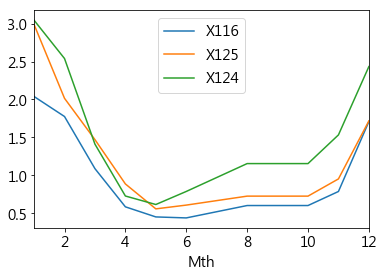

In [709]:
test1.groupby('Mth')[rd_test1].mean().plot()

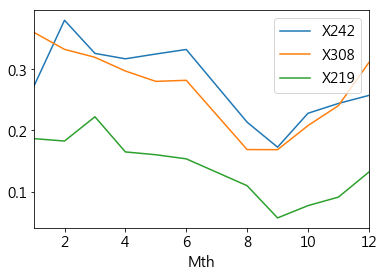

In [710]:
test1.groupby('Mth')[rd_test2].mean().plot()

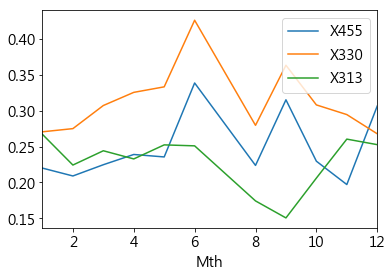

In [711]:
test1.groupby('Mth')[rd_test3].mean().plot()

In [712]:
test1.groupby('season')[clusters[k-1]].mean()

X403      X389      X377
season                              
1       0.167228  0.270316  0.139131
2       0.192559  0.337928  0.182553
3       0.171004  0.244648  0.131463
4       0.189383  0.263959  0.101902

# 그래프그래프그으으으래래래ㅐㄹ프 그려라 

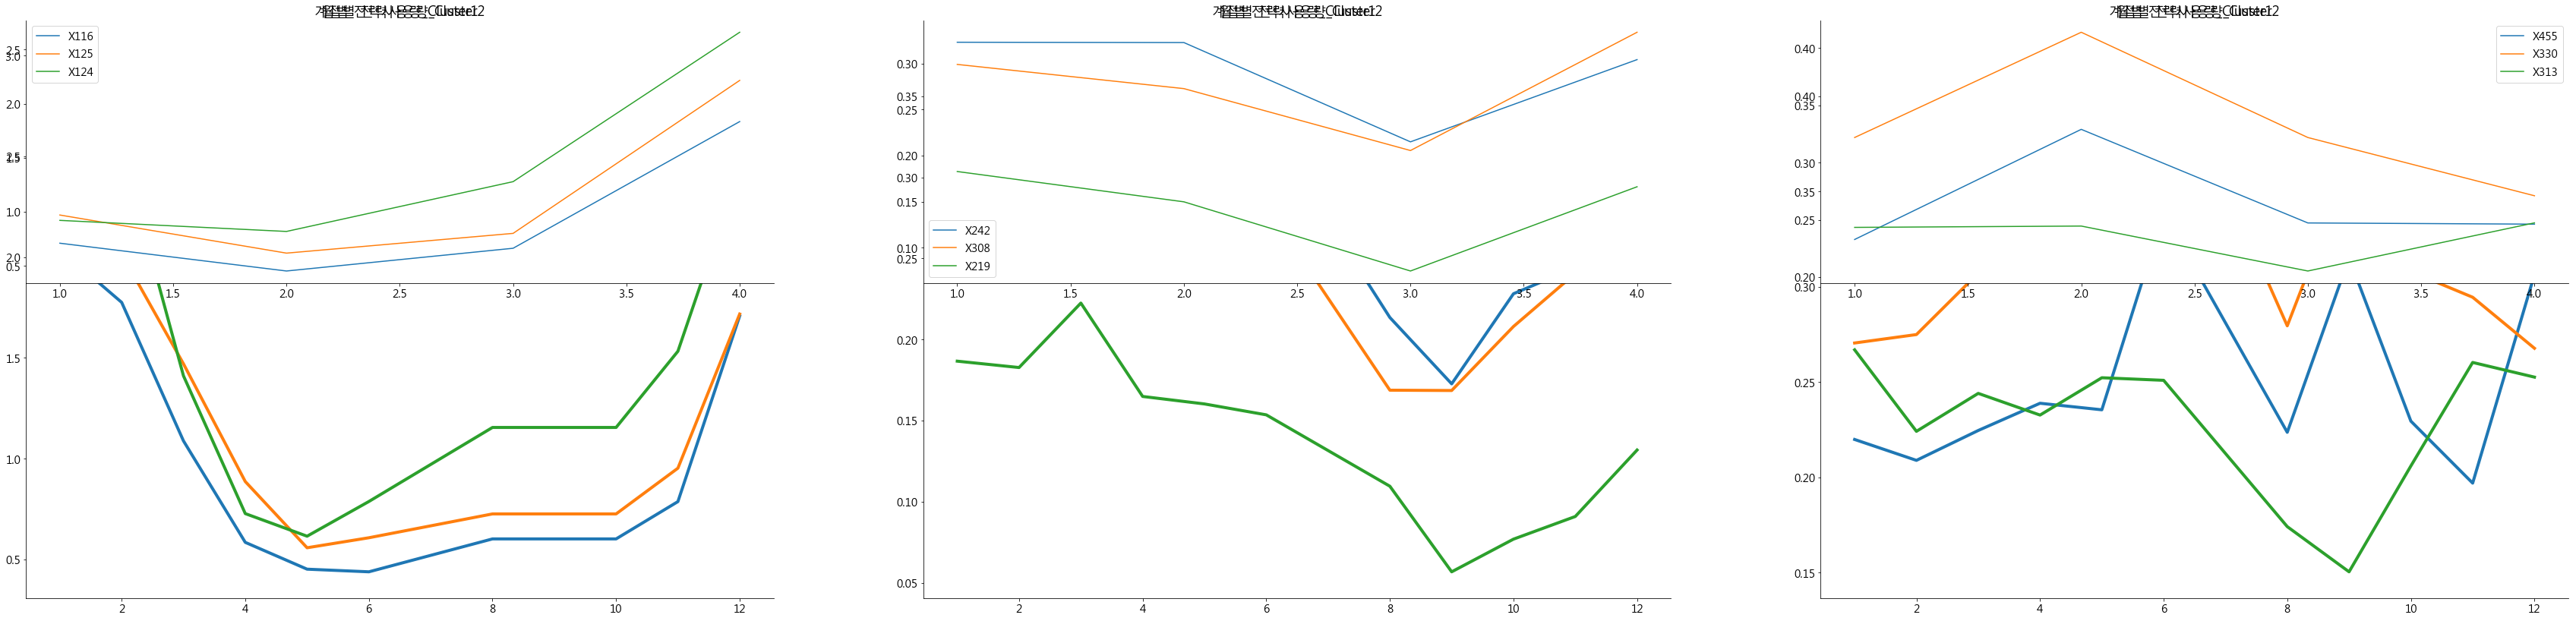

In [713]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(60,14))
clusters = [rd_test1, rd_test2, rd_test3]

for i in range(1,3):
    for k in range(1,4):
        ax = fig.add_subplot(i,3,k)
        ax.spines['top'].set_visible(False) ; ax.spines['right'].set_visible(False)
        if i==1:
            ax.set_title('월별 전력사용량_Cluster'+str(i))
            ax.plot(test1.groupby('Mth')[clusters[k-1]].mean(), linewidth=4.0)  
        else:
            ax.set_title('계절별 전력사용량_Cluster'+str(i))
            ax.plot(test1.groupby('season')[clusters[k-1]].mean())

        ax.legend(clusters[k-1])

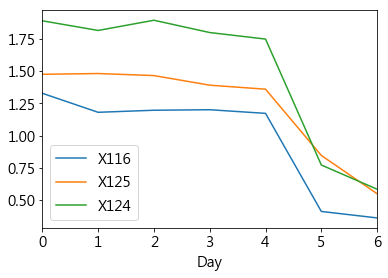

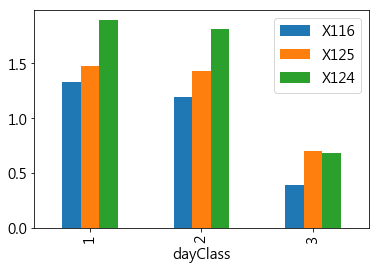

In [723]:
test1.groupby('Day')[clusters[0]].mean().plot()
test1.groupby('dayClass')[clusters[0]].mean().plot.bar()

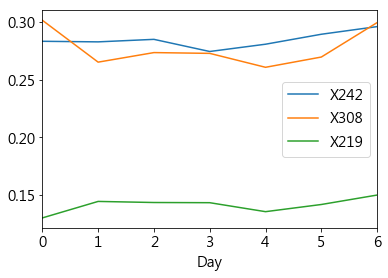

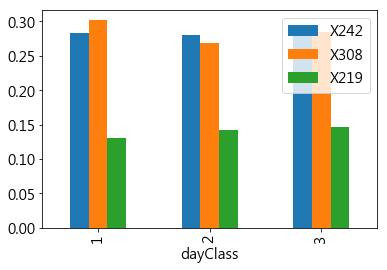

In [724]:
test1.groupby('Day')[clusters[1]].mean().plot()
test1.groupby('dayClass')[clusters[1]].mean().plot.bar()

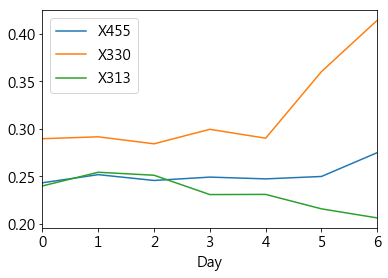

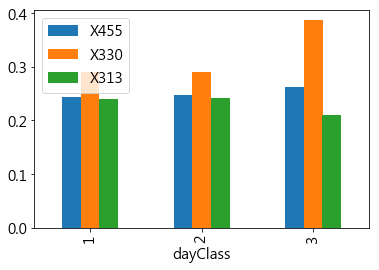

In [725]:
test1.groupby('Day')[clusters[2]].mean().plot()
test1.groupby('dayClass')[clusters[2]].mean().plot.bar()

In [714]:
def dummies(df, dum_lst):
    df1 = df.copy()
    # dum_lst에 들어있는 각각의 변수마다 
    # tmp = get_dummies, 해당 original 변수는 drop
    # tmp와 변수가 drop된 df를 join 후 리턴
    for v in dum_lst:
        tmp = pd.get_dummies(df1[v], prefix=v)
        df1 = df1.drop(columns=v).join(tmp)
    return df1

In [727]:
test2 = dummies(test1, ['Mth', 'season', 'dayClass','Day'])

# XGBoost Reg

In [728]:
test2.head(1)

X26   X303   X241   X435   X402   X352   X305  \
Time                                                                      
2017-08-29 10:00:00  1.473264  0.431  0.276  0.228  0.432  0.232  0.348   

                      X350   X326   X299  ...  dayClass_1  dayClass_2  \
Time                                      ...                           
2017-08-29 10:00:00  0.259  0.194  0.086  ...           0           1   

                     dayClass_3  Day_0  Day_1  Day_2  Day_3  Day_4  Day_5  \
Time                                                                        
2017-08-29 10:00:00           0      0      1      0      0      0      0   

                     Day_6  
Time                        
2017-08-29 10:00:00      0  

[1 rows x 227 columns]

In [733]:
data = pd.DataFrame(test2.X303)
data.columns=['y']

for i in [24, 168]:
    data['lag_{}'.format(i)] = data.y.shift(i)

In [734]:
data.head()

y  lag_24  lag_168
Time                                       
2017-08-29 10:00:00  0.431     NaN      NaN
2017-08-29 11:00:00  0.398     NaN      NaN
2017-08-29 12:00:00  0.427     NaN      NaN
2017-08-29 13:00:00  0.727     NaN      NaN
2017-08-29 14:00:00  1.208     NaN      NaN

In [741]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    return X_train, X_test, y_train, y_test

def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

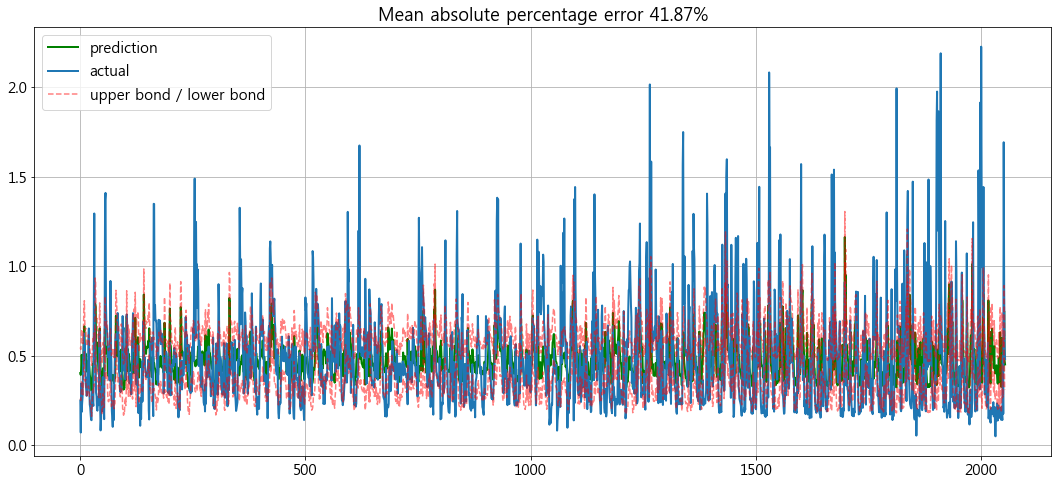

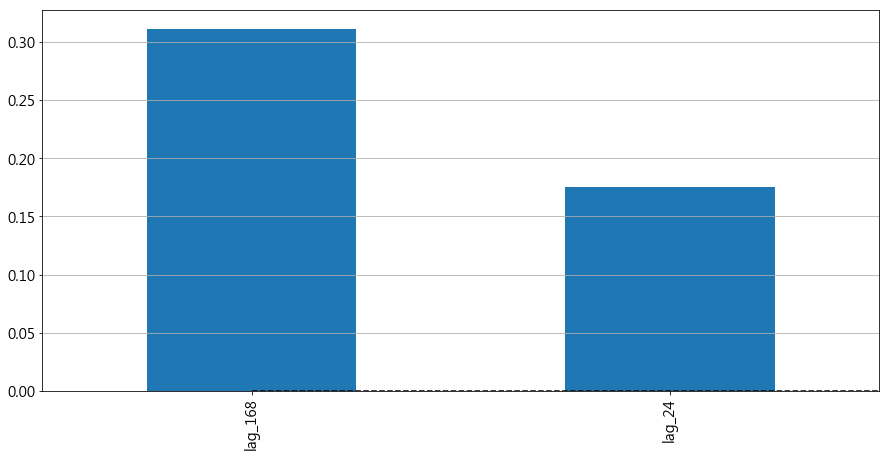

In [742]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, X_train, X_test, plot_intervals=True)
plotCoefficients(lr)